# Classifying elliptic curves by complex multiplication

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from tqdm.notebook import *
from math import *
from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import tree
import matplotlib
import seaborn as sns
from helpers import *

In [3]:
df = pd.read_csv("output/dataset.csv")

In [4]:
df.head()

,A2,A3,A5,A7,A11,A13,A17,A19,A23,A29,...,A967,A971,A977,A983,A991,A997,CONDUCTOR,L1,J,CM
0,0.000000,0.000000,-0.894427,0.377964,-0.904534,1.386750,0.970143,0.000000,1.251086,-0.185695,...,-1.350629,1.059020,-0.575871,0.127580,-0.889449,0.316703,413858.0,0.000000,3720.283610,0.0
1,0.000000,-1.154701,-0.894427,-0.755929,1.206045,-1.664101,0.000000,0.229416,-0.625543,0.185695,...,0.257263,-0.288824,1.631635,-0.765481,-0.635321,1.330153,77452.0,0.468801,122.268657,0.0
2,0.000000,1.732051,0.000000,-0.755929,-0.904534,1.664101,-0.242536,0.917663,0.625543,0.000000,...,-1.286313,0.353007,0.639857,-1.594752,0.889449,1.963560,24280.0,4.277669,0.728778,0.0
3,-1.414214,0.000000,0.894427,-1.511858,-0.603023,0.832050,1.212678,-0.917663,0.834058,-0.742781,...,0.257263,-0.962746,-0.991778,-0.095685,-1.270642,-0.443384,197611.0,0.000000,-97.189688,0.0
4,0.707107,0.000000,-0.894427,1.511858,-1.206045,-0.554700,-1.455214,0.000000,1.251086,-0.371391,...,1.479260,0.000000,-0.063986,1.148222,-0.254128,0.696747,166041.0,0.000000,13202.519497,0.0


In [8]:
L1_ONLY = False
SOPHIE_GERMAIN = False
RUN_NN = False

In [9]:
if L1_ONLY:
    df = df[["L1","CM"]]
if not SOPHIE_GERMAIN:
    X = np.array(df)
    X = np.delete(X, len(X[0])-1, 1)
    Y = np.array(df["CM"])
    indexes = df.columns.values[:-1]
else:
    indexes=[]
    for x in df.columns.values:
        if x == "CM":
            continue
        if is_sg(int(x[1:])) or is_safe(int(x[1:])):
            indexes.append(x)
    X = np.array(df[indexes])
    Y = np.array(df["CM"])

In [10]:
X.shape

(5000, 171)

In [11]:
df["CM"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4995    1.0
4996    1.0
4997    1.0
4998    1.0
4999    1.0
Name: CM, Length: 5000, dtype: float64

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = True)
assert 0.4 < len(Y_train[Y_train==1])/len(Y_train) < 0.6, "Imbalanced train dataset"
assert 0.4 < len(Y_test[Y_test==1])/len(Y_test) < 0.6, "Imbalanced test dataset"

In [13]:
def ma_sampling(x: list, win = 28): # For pretty plots
    assert len(x)>win, "Window too large!"
    cur_sum = sum(x[:win])
    cur_pos = win - 1
    sampled = []
    for i in range(len(x)-win):
        sampled.append(cur_sum/win)
        cur_sum -= x[cur_pos-win]
        cur_pos += 1
        cur_sum += x[cur_pos]
    return sampled

In [14]:
def acc(X,Y):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = torch.tensor(X[i], dtype=torch.double).float()
        y = Y[i]
        _y = model(x)
        if _y[0] > _y[1]:
            cls = 0
        else:
            cls = 1
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

## Neural network model

/home/p01ar/DataspellProjects/EllipticCurves/venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


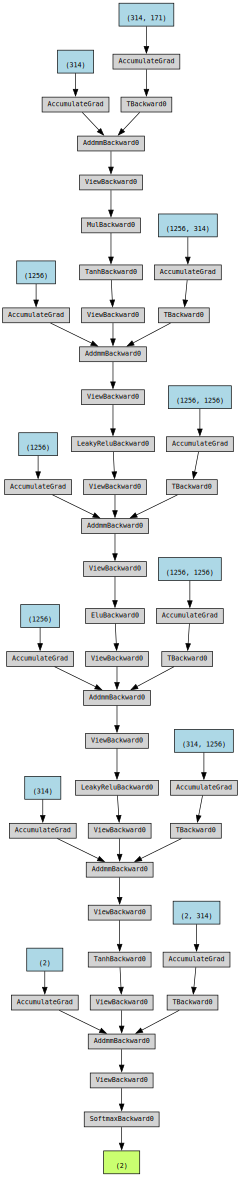

In [16]:
from torchviz import make_dot
DATA_SIZE = len(X[0])
N_EPOCHS = 2000
N_DISPLAY = 20
SAMPLE_SIZE = 100
A=314
k=4
model = nn.Sequential(
        nn.Linear(DATA_SIZE, A),
        nn.Dropout(0.1),
        nn.Tanh(),
        nn.Linear(A, k*A),
        nn.LeakyReLU(),
        nn.Linear(k*A, k*A),
        nn.ELU(),
        nn.Linear(k*A, k*A),
        nn.LeakyReLU(),
        nn.Linear(k*A, A),
        nn.Tanh(),
        nn.Linear(A, 2),
        nn.Softmax()
)
criterion = nn.CrossEntropyLoss() # The MOST inconvinient criterion ever!
optimizer = optim.SGD(model.parameters(), lr=0.01)
#print("Untrained accuracy(test): %.3f"%acc(X_test, Y_test))
#print("Untrained accuracy(train): %.3f"%acc(X_train, Y_train))
x = torch.tensor(X[0], dtype=torch.double).float()
y = model(x)
make_dot(y)

In [17]:
if RUN_NN:
    losses = []
    plotlosses = PlotLosses()
    avg_loss_lr = 0.0
    avg_accuracy = 0.0
    for i in tnrange(N_EPOCHS):
        indices = np.random.choice(X_train.shape[0], SAMPLE_SIZE, replace=False)
        sample_x = X_train[indices]
        sample_y = Y_train[indices]
        avg_loss = 0.0
        for j in range(SAMPLE_SIZE):
            x = torch.Tensor(sample_x[j])
            target = torch.Tensor([int(sample_y[j])]).type(torch.LongTensor)
            optimizer.zero_grad()   
            output = model(x)
            output = output.reshape((1,2)).float()
            loss = criterion(output, target)
            avg_loss += float(loss)
            loss.backward()
            optimizer.step()
        avg_loss /= SAMPLE_SIZE
        avg_loss_lr += avg_loss
        #avg_accuracy += acc(X_test, Y_test)
        if i % N_DISPLAY == 0 and i > 0:
            avg_loss_lr /= N_DISPLAY
            #avg_accuracy /= N_DISPLAY
            plotlosses.update({"Loss": avg_loss_lr, "Accuracy": acc(X_test, Y_test)})
            plotlosses.send()
            avg_loss_lr = 0.0
            avg_accuracy = 0.0
        losses.append(avg_loss)

In [18]:
if RUN_NN:
    plt.plot(ma_sampling(losses))
    plt.show()

In [19]:
print("Acc(train): %.3f"%acc(X_train, Y_train))
print("Acc(test): %.3f"%acc(X_test, Y_test))

/home/p01ar/DataspellProjects/EllipticCurves/venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Acc(train): 0.523
Acc(test): 0.559


As it can be seen neural networks are absolutely useless for classifying _~~anything~~_ elliptic curves.

## Naive Bayesian classifier

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
naive_bayes = GaussianNB()
naive_bayes.fit(X_train , Y_train)
Y_predicted = naive_bayes.predict(X_test)
print("Acc: %.3f" % metrics.accuracy_score(Y_predicted , Y_test))

Acc: 0.559


In [21]:
X_train[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.88982237e+00,
        0.00000000e+00,  1.38675049e+00,  0.00000000e+00,  1.83532587e+00,
        0.00000000e+00,  0.00000000e+00, -1.25723711e+00, -1.64398987e+00,
        0.00000000e+00,  1.21998856e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.79251632e+00,  1.34386389e+00,  0.00000000e+00,
        1.98969950e+00, -1.46261427e+00,  0.00000000e+00,  0.00000000e+00,
        5.07673083e-01,  0.00000000e+00, -6.89730495e-01,  0.00000000e+00,
        1.62830468e+00,  0.00000000e+00, -1.68597737e+00,  0.00000000e+00,
        0.00000000e+00,  1.95083454e+00,  0.00000000e+00, -1.54619807e+00,
       -1.99521721e+00,  1.33154276e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.41225888e+00,  0.00000000e+00,  1.43963150e-01,
        0.00000000e+00, -1.98486737e+00, -1.10148543e+00,  3.34824765e-01,
        0.00000000e+00, -1.45380092e+00,  0.00000000e+00,  0.00000000e+00,
        1.09506626e+00,  

## Convolutional neural network

In [22]:
if RUN_NN:
    model = nn.Sequential(
            nn.Conv1d(1, 1, 64),
            nn.MaxPool1d(8),
            nn.LeakyReLU(),
            nn.Linear(145,290),
            nn.Tanh(),
            nn.Linear(290,145),
            nn.LeakyReLU(),
            nn.Linear(145,2)
    )
    x = torch.tensor(X_train[0], dtype=torch.double).float().reshape((1,1,1229))

In [23]:
if RUN_NN:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

In [24]:
def acc(X,Y):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = torch.tensor(X[i], dtype=torch.double).float().reshape((1,1,1229))
        y = Y[i]
        _y = model(x)
        if _y[0][0][0] > _y[0][0][1]:
            cls = 0
        else:
            cls = 1
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

In [25]:
if RUN_NN:    
    DATA_SIZE = len(X[0])
    N_EPOCHS = 800
    N_DISPLAY = 20
    SAMPLE_SIZE = 100
    losses = []
    plotlosses = PlotLosses()
    avg_loss_lr = 0.0
    avg_accuracy = 0.0
    for i in tnrange(N_EPOCHS):
        indices = np.random.choice(X_train.shape[0], SAMPLE_SIZE, replace=False)
        sample_x = X_train[indices]
        sample_y = Y_train[indices]
        avg_loss = 0.0
        for j in range(SAMPLE_SIZE):
            x = torch.Tensor(sample_x[j]).reshape((1,1,1229))
            target = torch.Tensor([int(sample_y[j])]).type(torch.LongTensor)
            optimizer.zero_grad()   
            output = model(x)
            output = output[0]
            loss = criterion(output, target)
            avg_loss += float(loss)
            loss.backward()
            optimizer.step()
        avg_loss /= SAMPLE_SIZE
        avg_loss_lr += avg_loss
        #avg_accuracy += acc(X_test, Y_test)
        if i % N_DISPLAY == 0 and i > 0:
            avg_loss_lr /= N_DISPLAY
            #avg_accuracy /= N_DISPLAY
            plotlosses.update({"Loss": avg_loss_lr, "Accuracy": acc(X_test, Y_test)})
            plotlosses.send()
            avg_loss_lr = 0.0
            avg_accuracy = 0.0
        losses.append(avg_loss)

In [26]:
if RUN_NN:    
    print("Acc(train): %.3f"%acc(X_train, Y_train))
    print("Acc(test): %.3f"%acc(X_test, Y_test))

Is this magic of random intialization?...or convolutional networks really suitable for working with big vectors? Anyway, lets save this network:

In [27]:
if RUN_NN:
    torch.save(model, "output/magic.th")

## Decision tree classifier


In [28]:
matplotlib.rc('figure', figsize=(20, 20))

In [29]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train, Y_train)

In [30]:
def acc(X,Y,fn):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = X[i]
        y = Y[i]
        _y = fn([x])
        cls = _y[0]
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

In [31]:
accuracy = acc(X_test, Y_test, model.predict)
print("Accuracy:", accuracy)
print("N correct:%d/%d"%(round(len(X_test)*accuracy), len(X_test)))

Accuracy: 0.9973333333333333
N correct:1496/1500


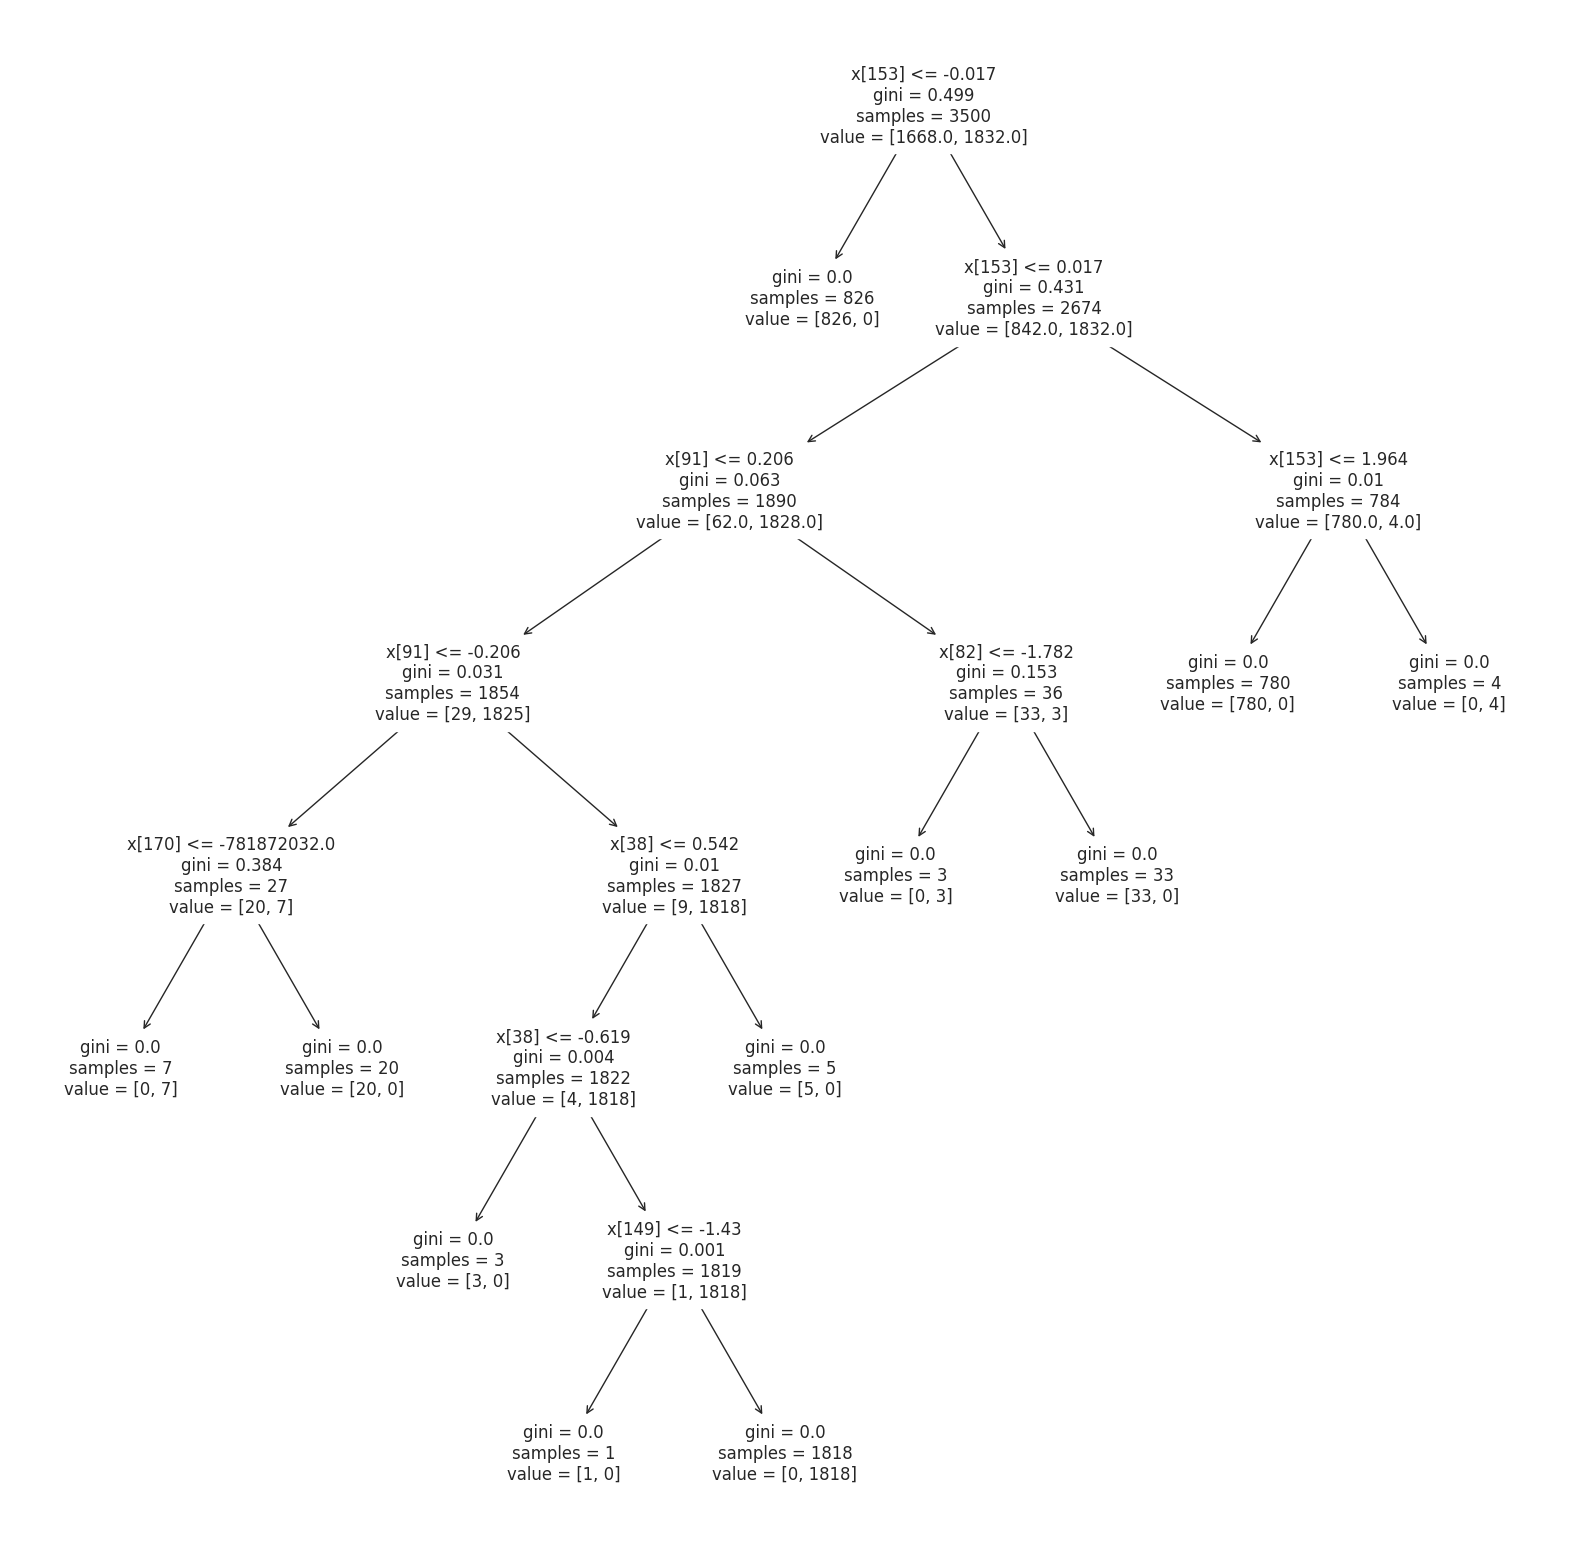

In [32]:
tree.plot_tree(model)
plt.plot(figsize=(10,10))
plt.show()

In [33]:
r = tree.export_text(model)

In [34]:
importances = list(model.feature_importances_)
for i in range(len(importances)):
    if importances[i] > 0.0:
        print(f"{indexes[i]} has importance {importances[i]}")

A167 has importance 0.009112824932307322
A431 has importance 0.0031497727582126445
A479 has importance 0.04933722424259064
A863 has importance 0.0011447422408777741
A887 has importance 0.9313164703559812
J has importance 0.005938965470030574


## Bootstrap
Lets build tree many(e.g. 20) times and see which features would be most important and whether corresponiding index is Sophie-Germain prime or safe prime.

In [35]:
def bootstrap_best_feature():
    model = tree.DecisionTreeClassifier()
    model = model.fit(X_train, Y_train)
    importances = list(model.feature_importances_)
    best_feature_n = None
    best_score = 0.0
    for feature_n in range(len(importances)):
        if importances[feature_n] > best_score:
            best_score = importances[feature_n]
            best_feature_n = feature_n
    return best_feature_n, best_score

In [36]:
best_coefs = []
best_trees = []
n = 1000
n_sg = 0
n_safe = 0
total_score = 0.0
for i in tnrange(n):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, shuffle = True)
    n_feature, score = bootstrap_best_feature()
    total_score += score
    prime = int(indexes[n_feature][1:])
    if is_sg(prime):
        n_sg += 1
    if is_safe(prime):
        n_safe += 1
    accuracy = acc(X_test, Y_test, model.predict)
    if accuracy == 1.0:
        best_trees.append(model)
    best_coefs.append(prime)
print(f"n_sg={n_sg}")
print(f"n_safe={n_safe}")
print(f"avg_score={total_score/n}")

  0%|          | 0/1000 [00:00<?, ?it/s]

n_sg=20
n_safe=955
avg_score=0.915655800138089


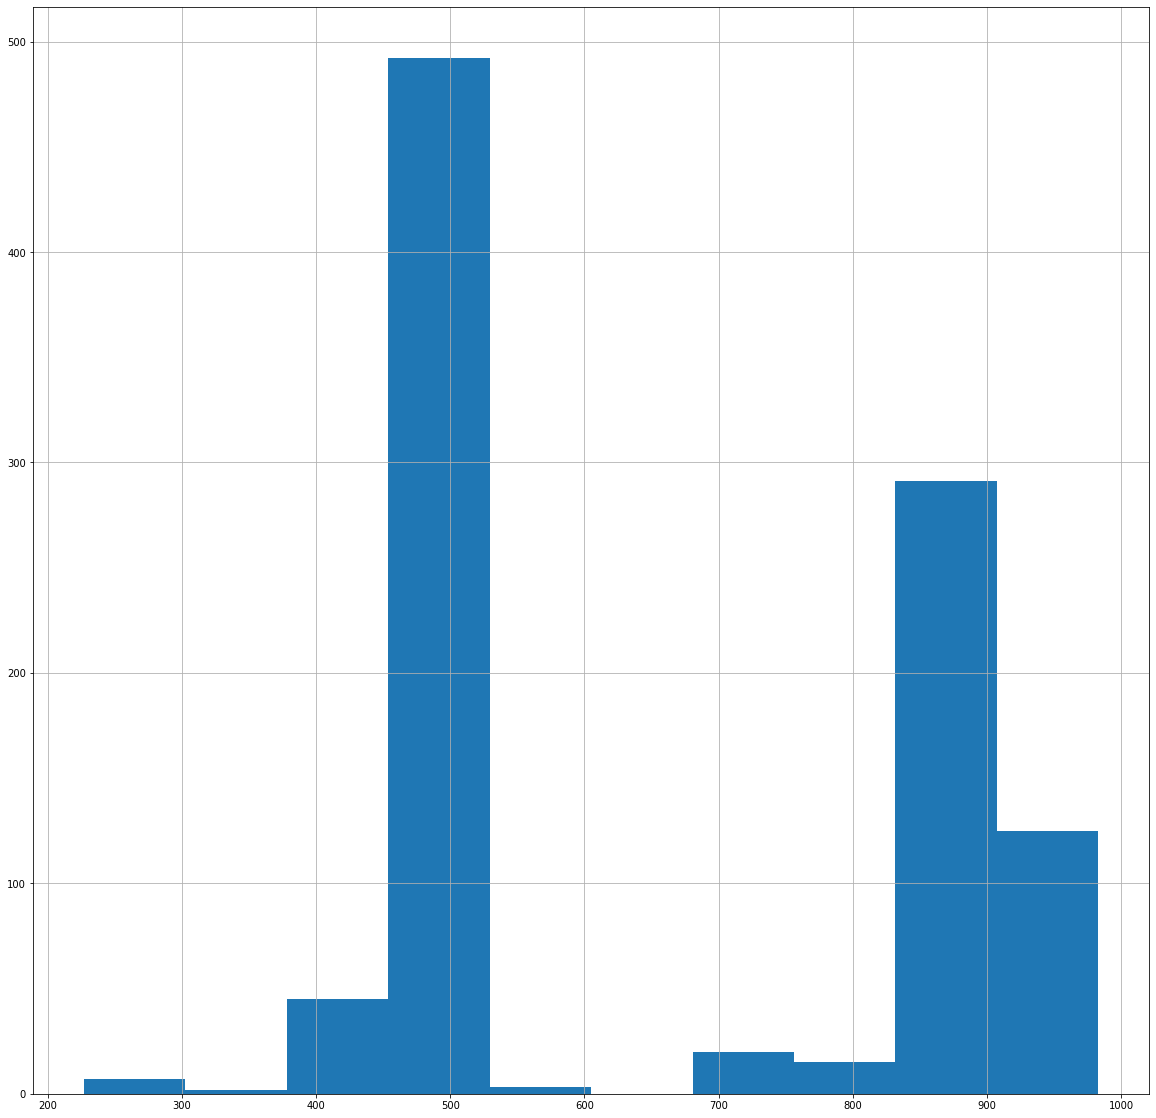

In [32]:
plt.hist(best_coefs)
plt.grid()
plt.show()

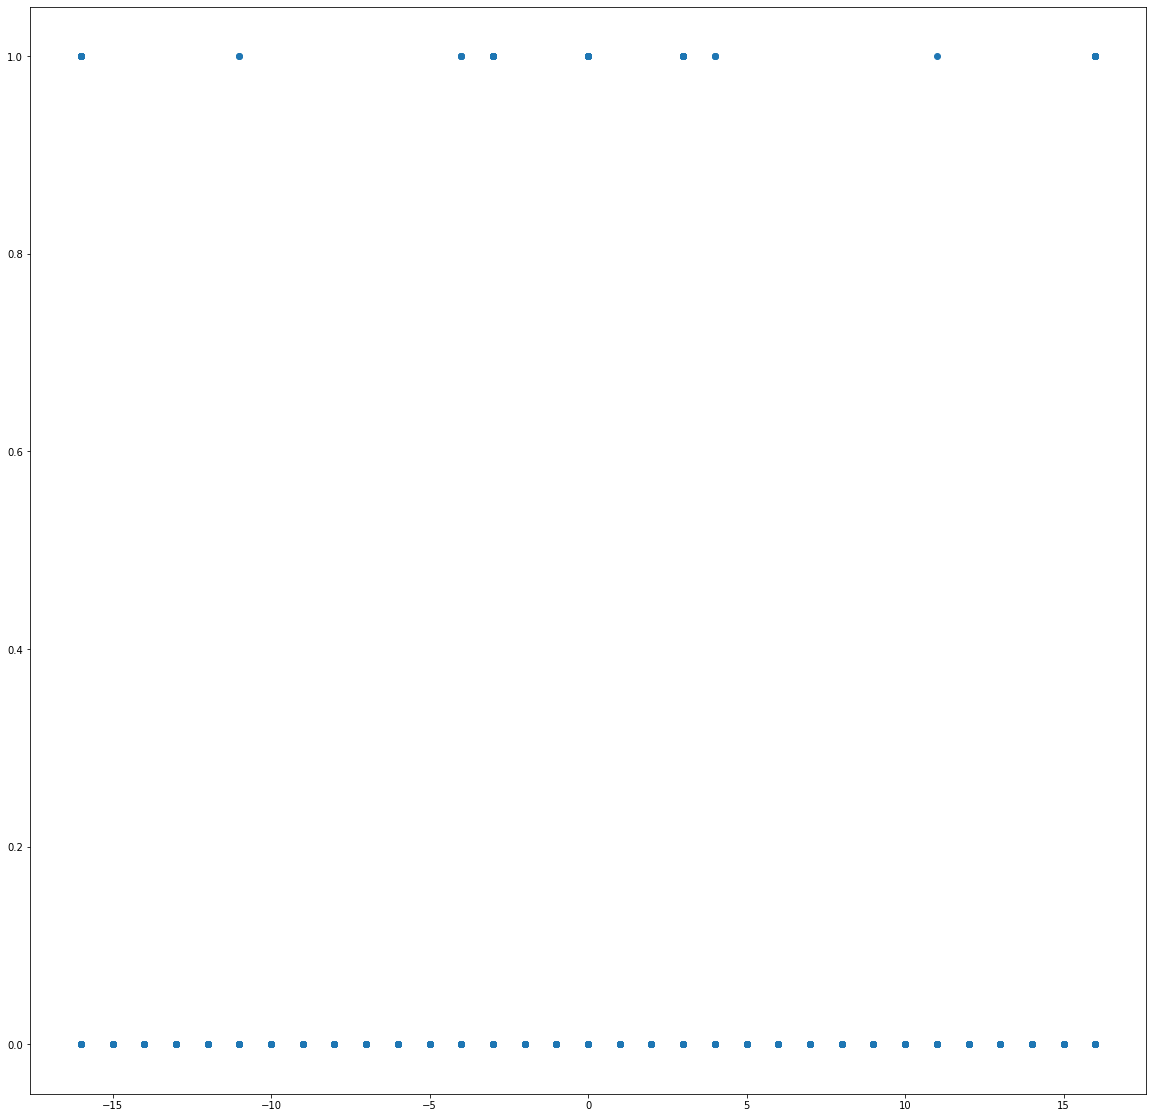

In [33]:
plt.scatter(df["A71"], df["CM"])
plt.show()

In [34]:
t = df[df["CM"]==0.0]

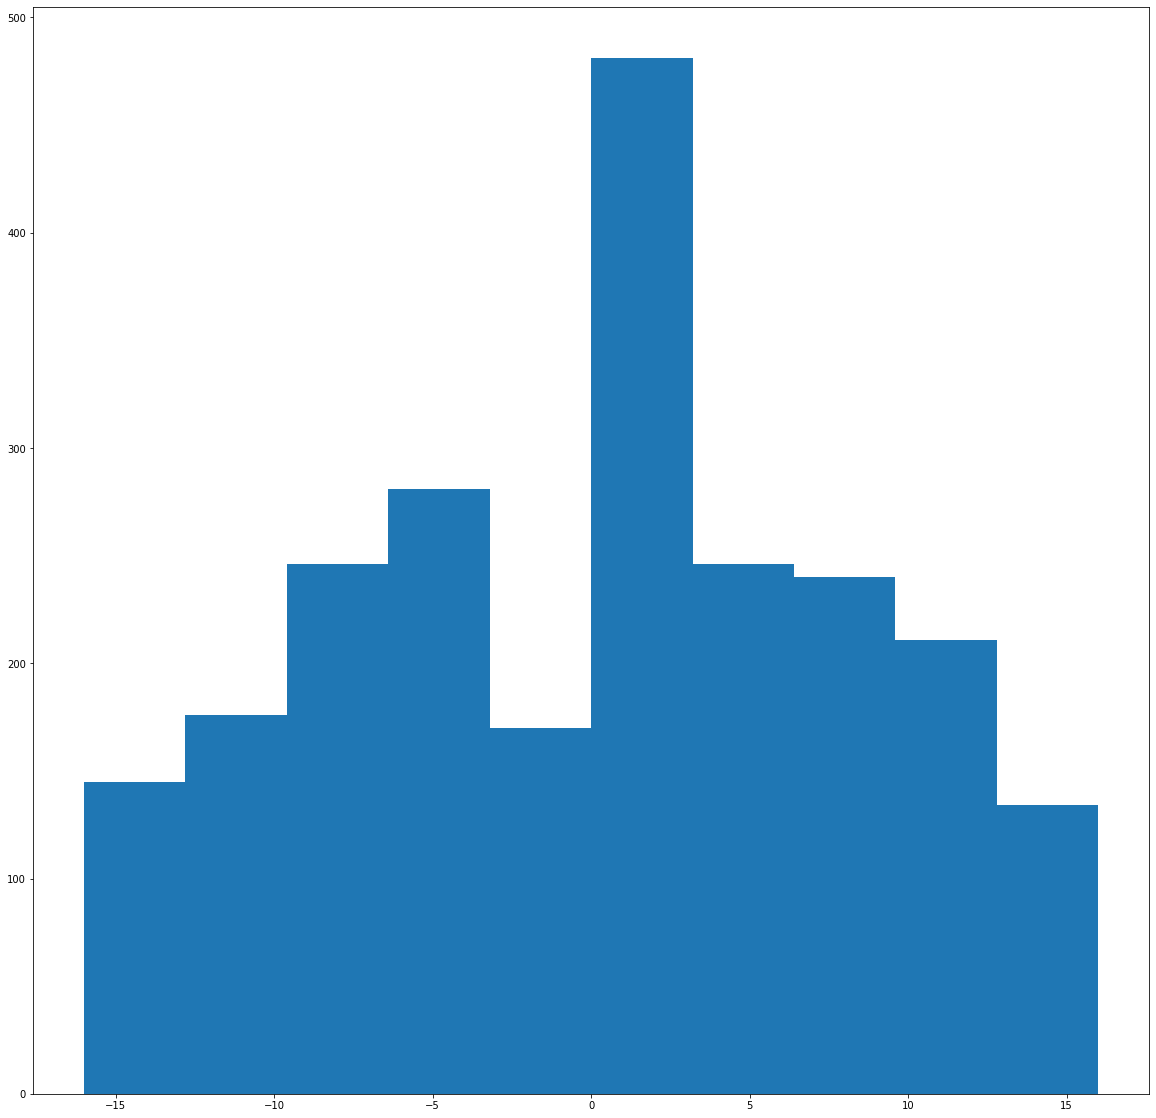

In [35]:
plt.hist(t["A71"])
plt.show()

<p>We can see that only 8 curve are classified incorrectly: they are said to be CM while they are not. This is exactly why tree adds additional conditions. It would be quite intresting to note that value of some $a_p$ being equal $0$ also means that elliptic curve singular in field modulo $p$. So we can predict that using random forest of trees built on different splits may increase accuracy up to $100\%$.<p>
<p>Using previously obtained data we can note that there is some coefficient which are zero when curve has CM.</p> 

**Conjecture(weak)**:
<br>
There is an infinite subset of primes $C\subset P$, s.t. for any elliptic curve $E$:
$$
\displaystyle
\forall p\in C: a_p=0 \Rightarrow E\in CM
$$
* $a_p$ is coefficients of Hasse-Weil $L$-function for 
* $CM$ set of elliptic curves with complex multiplication

**Conjecture(strong)**:
<br>
There is a finite subset of primes $C\subset P$, s.t. for any elliptic curve $E$:
$$
\displaystyle
\forall p\in C: a_p=0 \Rightarrow E\in CM
$$
* $a_p$ is coefficients of Hasse-Weil $L$-function for 
* $CM$ set of elliptic curves with complex multiplication

## $L(E,1)$ 

As BSD conjecture suggests the elliptic curve rank can depend on $L$-function at point $1$.

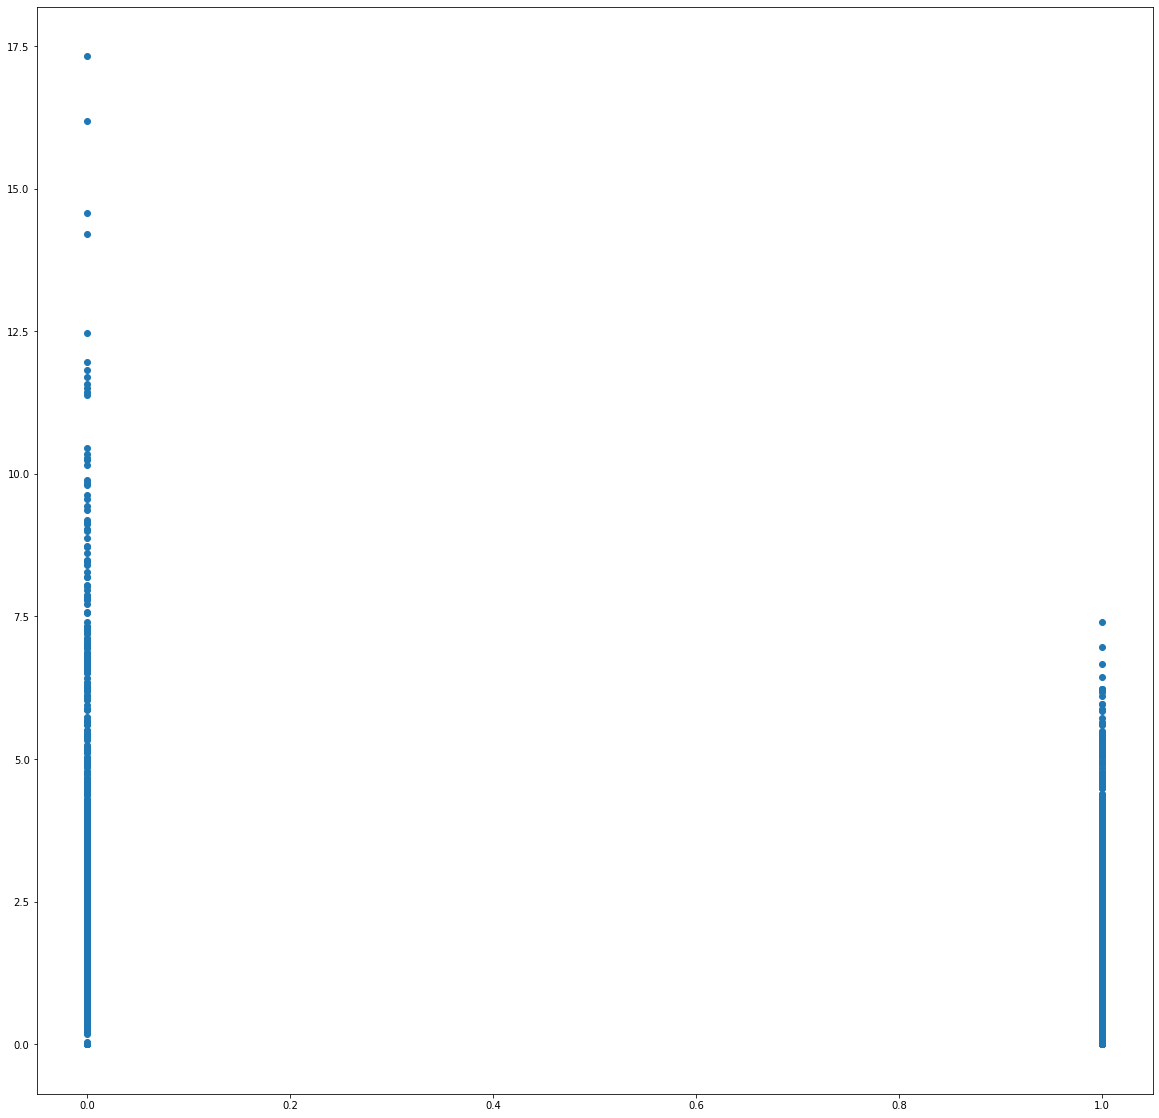

In [37]:
plt.scatter(df["CM"], df["L1"])
plt.show()

In [38]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train, Y_train)

In [39]:
accuracy = acc(X_test, Y_test, model.predict)
print("Accuracy:", accuracy)
print("N correct:%d/%d"%(round(len(X_test)*accuracy), len(X_test)))

Accuracy: 0.9936
N correct:2484/2500


## $j$-invariant analysis

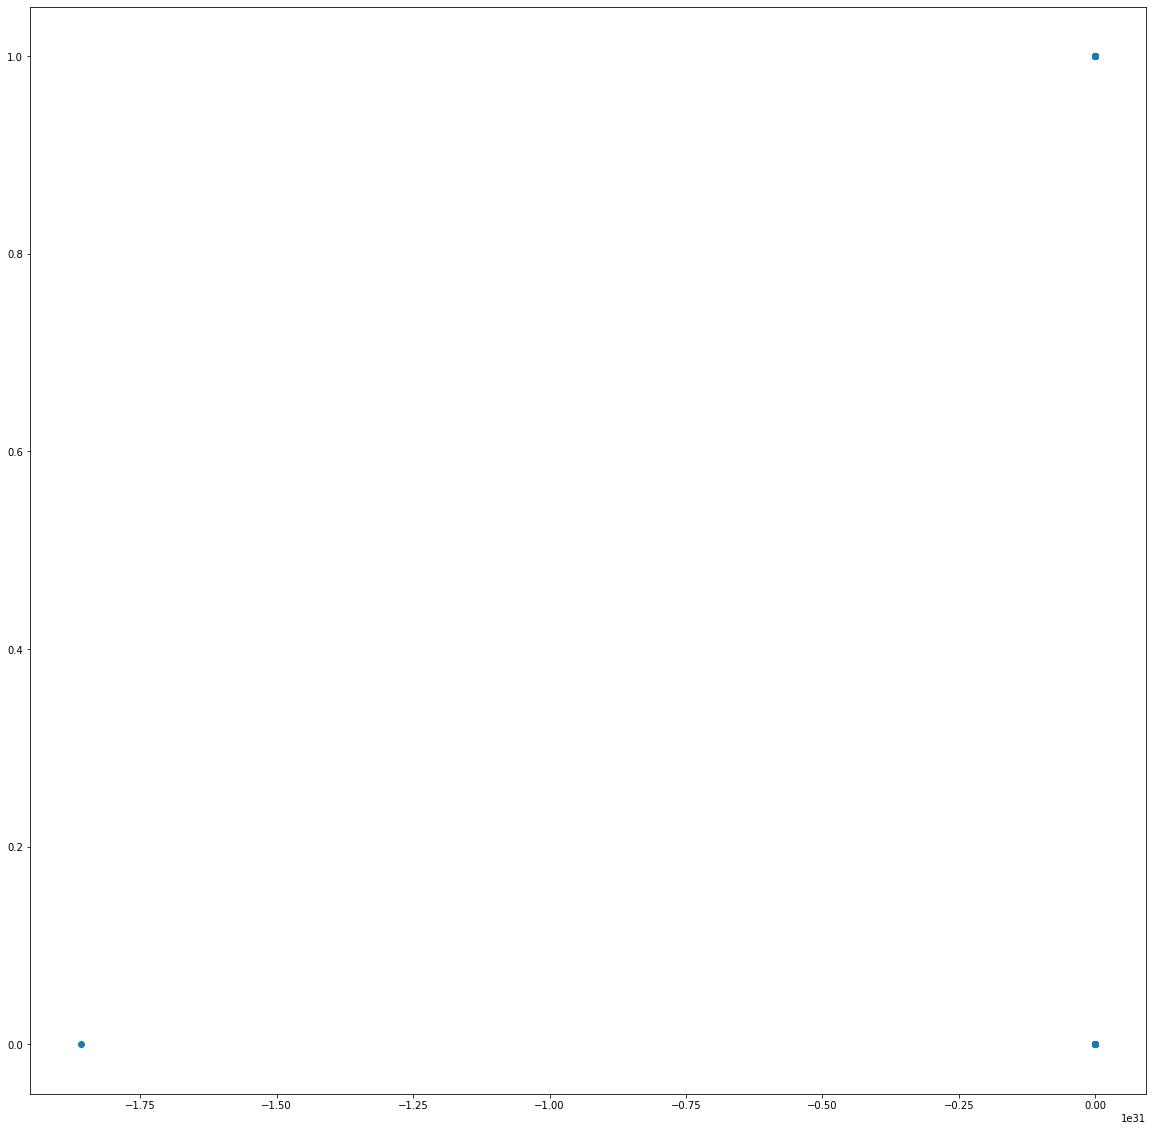

In [40]:
plt.scatter(df["J"], df["CM"])
plt.show()

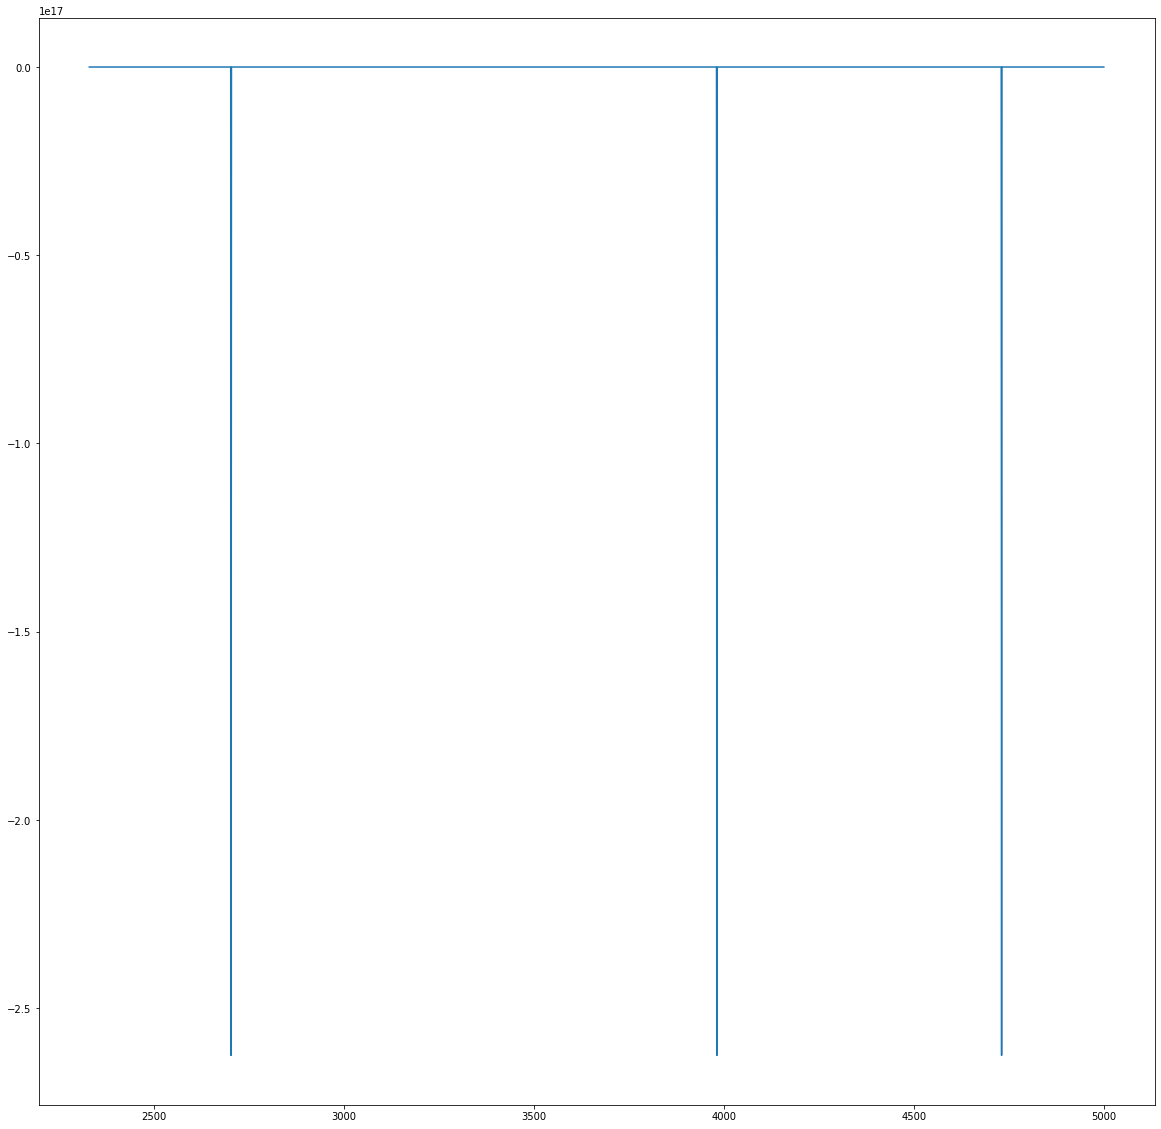

In [41]:
plt.plot(df[df["CM"]==1]["J"])
plt.show()

In [42]:
j_CM = set(df[df["CM"]==1]["J"])
j_CM

{-2.62537412640768e+17,
 -147197952000.0,
 -884736000.0,
 -884736.0,
 -32768.0,
 -3375.0,
 0.0,
 1728.0,
 8000.0}

In [43]:
j_nonCM = set(df[df["CM"]==0]["J"])
j_nonCM

{335872.98820004024,
 -1589248.1236449496,
 2.5382723883556757,
 2.301639344262295,
 -8188.753147440082,
 5.109691935809295,
 66871301.78693215,
 7.53626010170947,
 7.029488901693451,
 24584.87101029221,
 8.90945697754957,
 11.12270150148239,
 12.381041982871029,
 13.901530274538263,
 12.140792886254168,
 15.16398358003866,
 15.67161182466539,
 -57330.95502431189,
 19.405775870944076,
 19.6942424164524,
 21.049219919999217,
 1392662.349071504,
 23.00144073346431,
 22.59391537490837,
 25.517030738502275,
 26.916743366466743,
 27.14027904097609,
 22.484499324653683,
 29.569961272941573,
 29.45430494234687,
 23.45288794103672,
 3137559.9113719505,
 33.95501900178298,
 33.43799841263842,
 33.06682613245627,
 34.13413808668115,
 37.38377842038064,
 38.23245072322777,
 33.42425775751033,
 -483294.8480076036,
 41.300104448088135,
 42.75716820866988,
 43.09744134013516,
 41.47054297526154,
 44.7841890168765,
 46.46052047828085,
 48.00005523142708,
 48.1401206239502,
 50.5726797631586,
 51.9369

## Can we use $j$-invariant to predict the CM?
BSD conjecture says that yes, lets verify that:

In [44]:
for x in j_CM:
    print(f"Is {x} in non-CM?", x in j_nonCM)

Is 0.0 in non-CM? False
Is 8000.0 in non-CM? False
Is -32768.0 in non-CM? False
Is 1728.0 in non-CM? False
Is -884736.0 in non-CM? False
Is -884736000.0 in non-CM? False
Is -147197952000.0 in non-CM? False
Is -2.62537412640768e+17 in non-CM? False
Is -3375.0 in non-CM? False


There is no need to build any model: the sets of $j$-invariants are well-splitted, so for this data set second corrollary of BSD conjecture works.

In [69]:
is_safe(511)

False

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


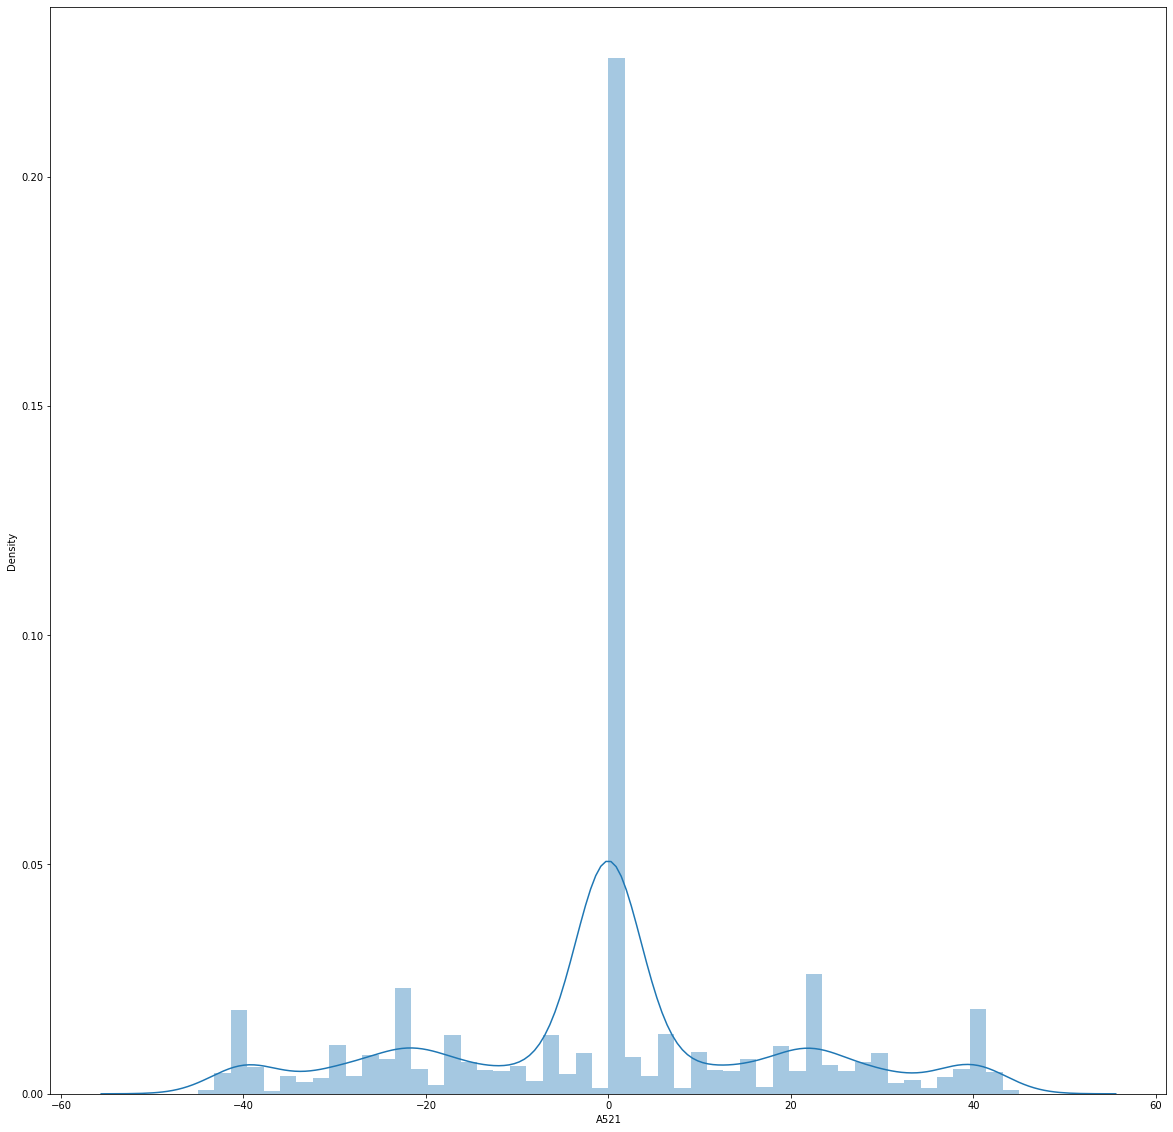

In [81]:
sns.distplot(df["A521"])
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


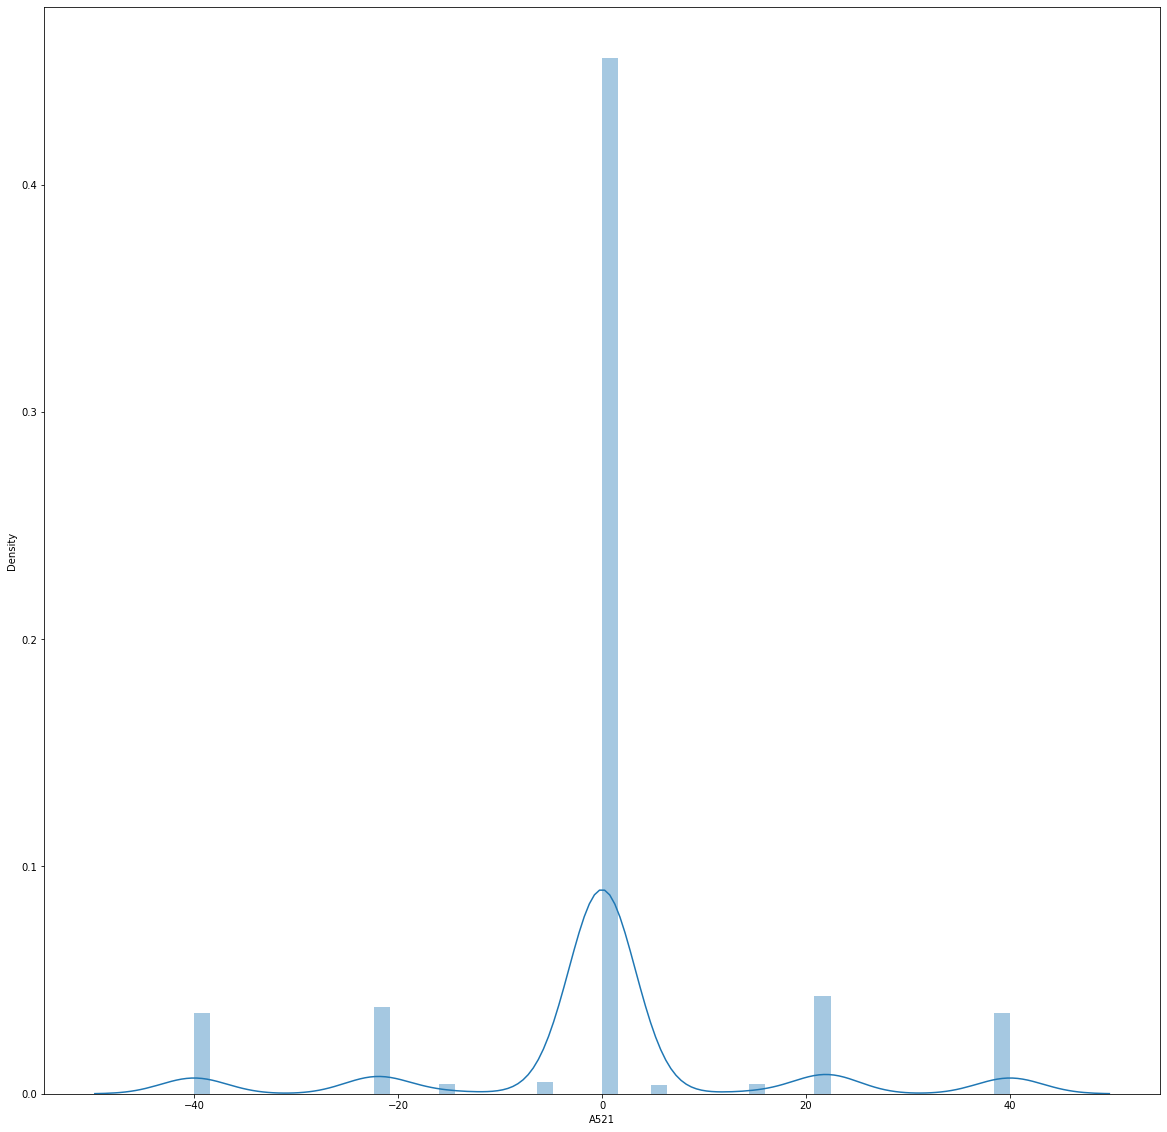

In [84]:
sns.distplot(df[df["CM"]==1]["A521"])
plt.show()

In [83]:
len(df[df["A521"]==0])

2018

In [77]:
is_sg(521)

False